# Mathematical Analysis of Machi Koro

In [1]:
import itertools
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import analysis
import data_files
import strategies

from importlib import reload
from machi_koro import cards
from machi_koro import game

In [20]:
pd.options.display.max_rows = None

## Part 1: The Dice

Roll each die, separately, 100 times on a flat surface.
Any rolls where the die hit another object were thrown out.

In [2]:
rolls = data_files.read_tsv('dice_rolls.tsv')

In [3]:
roll_counts = pd.DataFrame({
    "Green": rolls["Green"].value_counts().sort_index(),
    "Blue": rolls["Blue"].value_counts().sort_index()
})

In [4]:
def expected_occurrences_per(n):
    return math.ceil(1 / 6 * n)

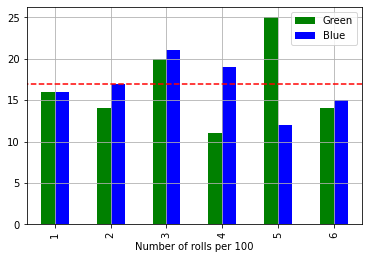

In [5]:
roll_counts.plot.bar(color=roll_counts.columns)
plt.xlabel("Number of rolls per 100")

# -1 is a hack to avoid having to re-index
xs = np.arange(-1, 7)
ys = [expected_occurrences_per(100)] * len(xs)
plt.plot(xs, ys, '--r')

plt.grid()

## Part 2: The Cards

- What is the expected value per roll for each card (assuming fair dice)?
- How long does it take for a card to break even in the best case?
- How long does it take for a card to break even in the average case?

### Expected value per roll

Neglecting the color effects of the cards, the expected coins for a card on a roll is given by:

$$
E(\text{card}) = Pr_{\text{dice}}(\text{card}) \cdot \text{Revenue}(\text{card})
$$

where $Pr_{\text{dice}}(\text{card})$ is the probability of activating that card (according to the number of dice used for the roll) and $\text{Revenue}(\text{card})$ is the number of coins generated by that card when it is activated.

More important is the **gross expected value**, which takes into account the color effects:

$$
E_{\text{gross}}(\text{card}, n) \equiv \frac{E_{\text{me}}(\text{card}) + (n - 1) \cdot E_{\text{them}}(\text{card})}{n}
$$

where $n$ is the number of players and

$$
\begin{align}
    E_{\text{color}}(\text{card}, \text{colors}) &\equiv E(\text{card}) \ \text{if card} \in \text{colors else} \ 0 \\
    E_{\text{me}}(\text{card}) &\equiv E_{\text{color}}(\text{card}, \{\text{Blue}, \text{Green}, \text{Purple}\}) \\
    E_{\text{them}}(\text{card}) &\equiv E_{\text{color}}(\text{card}, \{\text{Red}, \text{Blue}\})
\end{align}
$$

In [6]:
# The factory cards depend on the other cards in your hand.
# Analyze using one of each kind of card they depend on.
hand = [
    cards.WheatField(),
    cards.Ranch(),
    cards.Forest()
]   

def analyze_cards(two_dice: bool):
    return pd.DataFrame({
        "Card": [card.name for card in cards.distinct_cards],
        "Expected coins per roll (2p)": [analysis.gross_expected_value(card, hand, two_dice, num_players=2) for card in cards.distinct_cards],
        "Expected coins per roll (3p)": [analysis.gross_expected_value(card, hand, two_dice, num_players=3) for card in cards.distinct_cards],
        "Expected coins per roll (4p)": [analysis.gross_expected_value(card, hand, two_dice, num_players=4) for card in cards.distinct_cards],
        "Minimum rolls for payoff (4p)": [analysis.fastest_payoff(card, hand, num_players=4) for card in cards.distinct_cards],
        "Expected rolls for payoff (4p)": [analysis.expected_payoff(card, hand, two_dice, num_players=4) for card in cards.distinct_cards]
    })

color_map = {
    cards.Color.RED:    "hsl(0, 65%, 80%)",
    cards.Color.GREEN:  "hsl(105, 65%, 80%)",
    cards.Color.BLUE:   "hsl(210, 65%, 80%)",
    cards.Color.PURPLE: "hsl(256, 65%, 80%)",
    cards.Color.GOLD:   "white"
}

def color_by_card(series):
    card = [c for c in cards.distinct_cards if c.name == series["Card"]][0]
    color = color_map[card.color]
    return [f"background: {color}"] * len(series)

def format_card_analysis(card_analysis: pd.DataFrame):
    return card_analysis.style \
        .format({
            "Expected coins per roll (2p)": "{:.2f}",
            "Expected coins per roll (3p)": "{:.2f}",
            "Expected coins per roll (4p)": "{:.2f}",
            "Minimum rolls for payoff (4p)": int,
            "Expected rolls for payoff (4p)": int
        }, na_rep="-") \
        .apply(color_by_card, axis=1) \
        .hide_index()

In [7]:
cards_one_die = analyze_cards(two_dice=False)

# We don't care about the rows for cards that need two dice to be activated (rows 9-).
format_card_analysis(cards_one_die[0:9])

Card,Expected coins per roll (2p),Expected coins per roll (3p),Expected coins per roll (4p),Minimum rolls for payoff (4p),Expected rolls for payoff (4p)
Wheat Field,0.17,0.17,0.17,1,6
Ranch,0.17,0.17,0.17,1,6
Bakery,0.17,0.11,0.08,4,12
Cafe,0.17,0.22,0.25,2,8
Convenience Store,0.25,0.17,0.12,4,16
Forest,0.17,0.17,0.17,3,18
Stadium,0.17,0.22,0.25,4,24
TV Station,0.42,0.28,0.21,8,34
Business Center,0.00,0.00,0.00,-,-


In [8]:
cards_two_dice = analyze_cards(two_dice=True)

# We don't care about the rows for the landmark cards (last 4 rows).
format_card_analysis(cards_two_dice[:-4])

Card,Expected coins per roll (2p),Expected coins per roll (3p),Expected coins per roll (4p),Minimum rolls for payoff (4p),Expected rolls for payoff (4p)
Wheat Field,0.00,0.00,0.00,1,-
Ranch,0.03,0.03,0.03,1,36
Bakery,0.04,0.03,0.02,4,48
Cafe,0.04,0.06,0.06,2,32
Convenience Store,0.12,0.08,0.06,4,32
Forest,0.11,0.11,0.11,3,27
Stadium,0.14,0.19,0.21,4,29
TV Station,0.35,0.23,0.17,8,41
Business Center,0.00,0.00,0.00,-,-
Cheese Factory,0.25,0.17,0.12,8,40


## Part 3: Evaluating strategies

There are four strategies we want to evaluate:
1. Buy Nothing
2. Buy Every Card
3. Big Convenience Store
4. Fast Train to Factory

We want to see which strategy leads to victory the fastest.
For this analysis, we won't take into the effects of other players' actions on the strategy or a card's effects on the other players.
Also, we'll ignore the fact that there are a limited number of each card in the deck.

We'll define a **strategy** as a mapping from each round number to a card to buy:

$$
\text{Strategy}: N \mapsto \text{Deck}
$$

So, a strategy here is essentially a "build order."
To be **valid**, a strategy must include buying all four victory cards and must not try to buy any card that it won't have the money for on a given turn (according to the **expected** number of coins on that turn as given by the equations below).

Define a player's **state** as a tuple of the cards a player has and their number of coins:

$$
\begin{align}
    \text{state}_{k} &\equiv \text{hand}_{k} \times N \\
    \text{hand}_{k} &\subset \text{Deck}
\end{align}
$$

During a player's own turn, the player's state is updated by

$$
\begin{align}
    \text{Turn}_{\text{me}}((\text{hand}_{k}, \text{money}_{k}), k) &= (\text{hand}_{k + 1}, \text{money}_{k + 1}) \\
    \text{money}_{k + 1} &= \text{money}_{k} + \sum_{\text{card} \in \text{hand}_{k}} E_{\text{me}}(\text{card}) - \text{Cost}(\text{Strategy}(k))\\
    \text{hand}_{k + 1} &= \text{hand}_{k} \cup \{ \text{Strategy}(k) \}
\end{align}
$$

During another player's turn, the player's state is updated by

$$
\begin{align}
    \text{Turn}_{\text{them}}(\text{hand}_{k}, \text{money}_{k}) &= (\text{hand}_{k}, \text{money}_{k + 1}) \\
    \text{money}_{k + 1} &= \sum_{\text{card} \in \text{hand}_{k}} E_{\text{them}}(\text{card})
\end{align}
$$

So, we will simply run these equations until all four victory cards are bought.

In [38]:
reload(strategies)
strategies.simulate(strategies.buy_nothing, num_players=4)

,Round,Turn,Coins,# Cards,# Victory Cards
0,0,NaN,3.000000,2,0
1,1,1.0,3.500000,2,0
2,1,2.0,3.666667,2,0
3,1,3.0,3.833333,2,0
4,1,4.0,4.000000,2,0
5,2,1.0,4.500000,2,0
6,2,2.0,4.666667,2,0
7,2,3.0,4.833333,2,0
8,2,4.0,5.000000,2,0
9,3,1.0,5.500000,2,0
